# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite2
from celerite2 import terms
import torch
import os
import scipy

# Import raw data

In [2]:
#Defining function to check if directory exists, if not it generates it
def check_and_make_dir(dir):
    if not os.path.isdir(dir):os.mkdir(dir)
#Base directory 
base_dir = '/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/'
#File containing temperature values
raw_T_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_P.csv', delimiter=',')
#Path to store model
model_save_path = base_dir+'Model_Storage/GP/'
check_and_make_dir(model_save_path)
#Path to store plots
plot_save_path = base_dir+'Plots/GP/'
check_and_make_dir(plot_save_path)

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_T_data[:, :4]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs_T.shape[1] #Number of outputs

# Plotting of the T-P profiles

In [ ]:
for raw_input, raw_output_T, raw_output_P in zip(raw_inputs,raw_outputs_T,raw_outputs_P):
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    ax.plot(raw_output_T, np.log(raw_output_P/1000), color='blue', linewidth=2)
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'log$_{10}$ Pressure (bar)')
    ax.set_title(rf'H$_2$O : {raw_input[0]} bar, CO$_2$ : {raw_input[1]} bar, LoD : {raw_input[2]:.0f} days, Obliquity : {raw_input[3]} deg')
    plt.show()

# Fitting data with a Gaussian Process (celerite) - trying it out on one T-P profile (Can't be generalized)

In [ ]:
key = 4

#Plot the T-P profile we want to look at
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[8, 6], gridspec_kw={'height_ratios':[3,1]})
ax1.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4], '.', color='blue', linewidth=2, label='Data')
ax1.invert_yaxis()
ax1.set_ylabel('Temperature (K)')
ax2.set_ylabel('Residuals')
ax2.set_xlabel(r'log$_{10}$ Pressure (bar)')
ax1.set_title(rf'H$_2$O : {raw_inputs[key][0]} bar, CO$_2$ : {raw_inputs[key][1]} bar, LoD : {raw_inputs[key][2]:.0f} days, Obliquity : {raw_inputs[key][3]} deg')

#GP
#Defining a quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

#Defining a non-periodic term
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(np.log(raw_outputs_P[4]/1000))

#Plot resulting GP fit
pred_T, variance = gp.predict(raw_outputs_T[4], t=np.log(raw_outputs_P[4]/1000), return_var=True)
sigma = np.sqrt(variance)
ax1.plot(np.log(raw_outputs_P[4]/1000), pred_T, label='initial guess')
ax1.fill_between(np.log(raw_outputs_P[4]/1000), pred_T - sigma, pred_T + sigma, color="C0", alpha=0.2)
ax2.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4]-pred_T)
ax2.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Fitting data with an Ensemble Conditional GP

## First step : partition data into a training set, and a testing set

In [3]:
#Defining partition of data used for 1. training and 2. testing
data_partition = [0.8, 0.2]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
train_outputs_P = raw_outputs_P[train_idx]

### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

## Second step : Building Sai's Conditional GP function

In [4]:
def Sai_CGP(obs_features, obs_labels, query_features):
    """
    Conditional Gaussian Process
    Inputs: 
        obs_features : ndarray (D, N)
            D-dimensional features of the N observation data points.
        obs_labels : ndarray (K, N)
            K-dimensional labels of the N observation data points.
        query_features : ndarray (D, 1)
            D-dimensional features of the query data point.
    Outputs:
        query_labels : ndarray (K, 1)
            K-dimensional labels of the query data point.

    """
    # Defining relevant covariance matrices
    ## Between feature and label of observation data
    Cyx = (obs_labels @ obs_features.T) / (obs_features.shape[0])
    ## Between feature and feature of observation data
    Cxx = (obs_features @ obs_features.T) / (obs_features.shape[0])
    ## Adding regularizer to avoid impossible inverses
    Cxx += 1e-8 * np.eye(Cxx.shape[0]) 

    query_labels = np.mean(obs_labels + (Cyx @ scipy.linalg.inv(Cxx) @ (query_features - obs_features)), axis=1)

    return query_labels

## Third step : Going through test set (query points), find observations in proximity, and use them to get guess labels for query point

In [5]:
# Variable to show plots or not 
show_plot = False

#Number of nearest neighbors to choose
N_neigbors = 100

#Initialize array to store residuals
input_output_residuals_T = np.zeros(test_outputs_T.shape, dtype=float)
input_output_residuals_P = np.zeros(test_outputs_P.shape, dtype=float)

for query_idx, (test_input, test_output_T, test_output_P) in enumerate(zip(test_inputs, test_outputs_T, test_outputs_P)):

    #Calculate proximity of query point to observations
    distances = np.sqrt( (test_input[0] - train_inputs[:,0])**2 + (test_input[1] - train_inputs[:,1])**2 + (test_input[2] - train_inputs[:,2])**2 + (test_input[3] - train_inputs[:,3])**2 )

    #Choose the N closest points
    N_closest_idx = np.argsort(distances)[:N_neigbors]
    prox_train_inputs = train_inputs[N_closest_idx, :]
    prox_train_outputs_T = train_outputs_T[N_closest_idx, :]
    prox_train_outputs_P = train_outputs_P[N_closest_idx, :]
    
    #Find the query labels from nearest neigbours
    model_test_output = Sai_CGP(prox_train_inputs.T, np.concat((prox_train_outputs_T, prox_train_outputs_P), axis=1).T, test_input.reshape((1, 4)).T)
    model_test_output_T = model_test_output[:O] 
    model_test_output_P = model_test_output[O:] 
    input_output_residuals_T[query_idx, :] = model_test_output_T - test_output_T
    input_output_residuals_P[query_idx, :] = (np.log10(model_test_output_P)/1000) - (np.log10(test_output_P)/1000)

    #Diagnostic plot
    if show_plot:
        fig, axs = plt.subplot_mosaic([['res_pressure', '.'],
                                       ['results', 'res_temperature']],
                              figsize=(8, 6),
                              width_ratios=(3, 1), height_ratios=(1, 3),
                              layout='constrained')
        for prox_idx in range(N_neigbors):axs['results'].plot(prox_train_outputs_T[prox_idx], np.log10(prox_train_outputs_P[prox_idx]/1000), '.', linestyle='-', color='red', alpha=0.1, linewidth=2, zorder=1)
        axs['results'].plot(model_test_output_T, np.log10(model_test_output_P/1000), '.', linestyle='-', color='green', linewidth=2, zorder=2)
        axs['results'].plot(test_output_T, np.log10(test_output_P/1000), '.', linestyle='-', color='blue', linewidth=2, zorder=2)
        axs['results'].invert_yaxis()
        axs['results'].set_ylabel(r'log$_{10}$ Pressure (bar)')
        axs['results'].set_xlabel('Temperature (K)')
        
        axs['res_temperature'].plot(input_output_residuals_T[query_idx, :], np.log10(test_output_P/1000), '.', linestyle='-', color='green', linewidth=2)
        axs['res_temperature'].axvline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_temperature'].set_xlabel('Residuals (K)')
        
        axs['res_pressure'].plot(test_output_T, input_output_residuals_P[query_idx, :], '.', linestyle='-', color='green', linewidth=2)
        axs['res_pressure'].axhline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_pressure'].invert_yaxis()
        axs['res_pressure'].set_ylabel('Residuals (bar)')
        
        plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.tight_layout()
        plt.show()

Temperature Residuals : Median = 0.34 K, Std = 15.12 K
Pressure Residuals : Median = -1.14776812e-09 K, Std = 1.35458351e-05 K


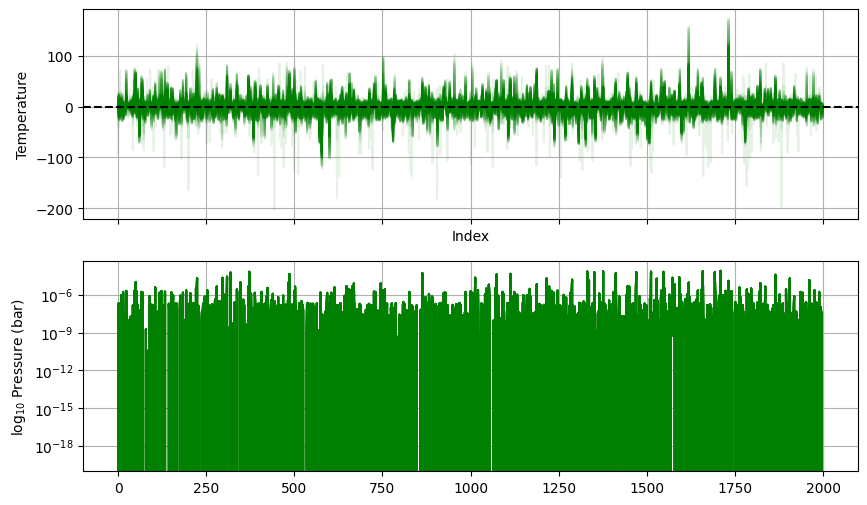

In [12]:
print(f'Temperature Residuals : Median = {np.median(input_output_residuals_T):.2f} K, Std = {np.std(input_output_residuals_T):.2f} K')
print(f'Pressure Residuals : Median = {np.median(input_output_residuals_P):.9} K, Std = {np.std(input_output_residuals_P):.9} K')

#Plot residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[10, 6])
ax1.plot(input_output_residuals_T, alpha=0.1, color='green')
ax2.plot(input_output_residuals_P, alpha=0.1, color='green')
for ax in [ax1, ax2]:ax.axhline(0, color='black', linestyle='dashed')
ax1.set_xlabel('Index')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('log$_{10}$ Pressure (bar)')
ax2.set_yscale('log')
for ax in [ax1, ax2]:ax.grid()
plt.show()